In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

from backend.common.state_resolver import resolve_state
from backend.ml.common import get_total_enrolment_series, get_total_biometric_series, list_districts


In [2]:
OUT_DIR = Path("reports")
OUT_DIR.mkdir(exist_ok=True)

OUT_IMG = OUT_DIR / "images"
OUT_IMG.mkdir(parents=True, exist_ok=True)

print("Reports folder:", OUT_DIR.resolve())


Reports folder: C:\Users\grimm\Hackathon\uidai_hackathon\notebooks\reports


Pull Top Priority States from backend logic (NO API call)

In [3]:
from sqlalchemy import func
from backend.db.session import SessionLocal
from backend.db.models import UIDAIRecord

from backend.ml.risk.scoring import compute_state_risk
from backend.ml.risk.recommend import recommend_actions

# 1) prefilter top states by total enrolment (fast SQL)
session = SessionLocal()

top_states = (
    session.query(
        UIDAIRecord.state,
        func.sum(UIDAIRecord.metric_value).label("total")
    )
    .filter(
        UIDAIRecord.dataset_type == "ENROLMENT",
        UIDAIRecord.metric_name.like("age_%")
    )
    .group_by(UIDAIRecord.state)
    .order_by(func.sum(UIDAIRecord.metric_value).desc())
    .limit(15)   # ✅ only evaluate top 15 states
    .all()
)

session.close()

states = [x[0] for x in top_states]
print("Scoring states:", states)

# 2) run ML only for these states
rows = []
for st in states:
    r = compute_state_risk(st)
    if r.get("status") != "success":
        continue
    rec = recommend_actions(st)

    rows.append({
        "state": st,
        "risk_score": r["risk_score"],
        "anomaly_severity": r["components"]["anomaly_severity"],
        "negative_gap_ratio": r["components"]["negative_gap_ratio"],
        "forecast_growth_log": r["components"]["forecast_growth_log"],
        "recommendations": "; ".join(rec.get("recommended_actions", []))
    })

df_top = pd.DataFrame(rows).sort_values("risk_score", ascending=False).head(10)
df_top


Scoring states: ['Uttar Pradesh', 'Bihar', 'Madhya Pradesh', 'West Bengal', 'Maharashtra', 'Rajasthan', 'Gujarat', 'Assam', 'Karnataka', 'Tamil Nadu', 'Jharkhand', 'Telangana', 'Andhra Pradesh', 'Odisha', 'Meghalaya']


,state,risk_score,anomaly_severity,negative_gap_ratio,forecast_growth_log,recommendations
8,Karnataka,2.446112,-0.270487,0.566667,5.846186,Investigate enrolment drop: possible connectiv...
6,Gujarat,2.413747,-0.274651,0.566667,5.725888,Investigate enrolment drop: possible connectiv...
10,Jharkhand,2.324091,-0.271836,0.600000,5.094403,High priority state: allocate additional resou...
5,Rajasthan,2.300204,-0.263165,0.500000,5.779779,High priority state: allocate additional resou...
3,West Bengal,2.172800,-0.257150,0.500000,5.256930,High priority state: allocate additional resou...
7,Assam,2.062205,-0.276950,0.500000,4.858111,High priority state: allocate additional resou...
11,Telangana,2.018548,-0.278033,0.600000,3.885864,Investigate enrolment drop: possible connectiv...
13,Odisha,2.006622,-0.278430,0.600000,3.839034,Investigate enrolment drop: possible connectiv...
12,Andhra Pradesh,2.000751,-0.278437,0.533333,4.348898,Investigate enrolment drop: possible connectiv...
9,Tamil Nadu,1.896629,-0.268363,0.533333,3.910249,Investigate enrolment drop: possible connectiv...


Plot Top 10 risky states

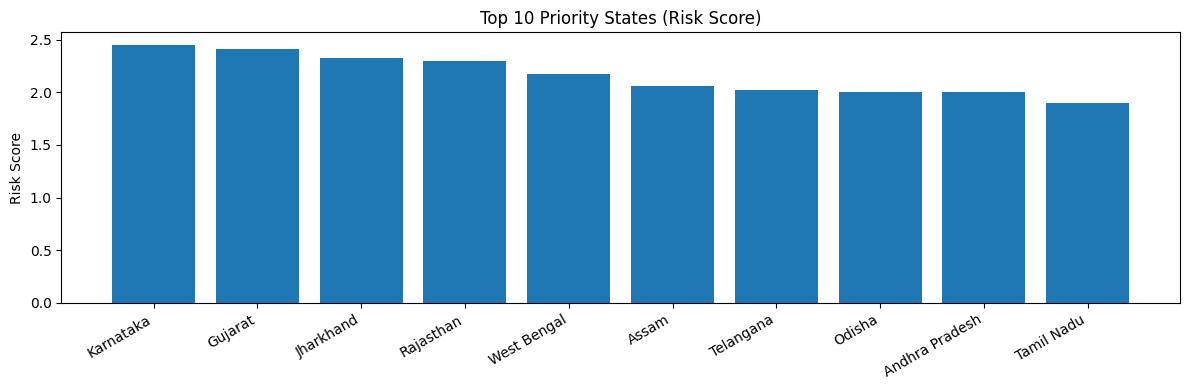

In [5]:
plt.figure(figsize=(12,4))
plt.bar(df_top["state"], df_top["risk_score"])
plt.xticks(rotation=30, ha="right")
plt.title("Top 10 Priority States (Risk Score)")
plt.ylabel("Risk Score")
plt.tight_layout()
plt.show()


In [6]:
img1 = OUT_IMG / "top10_states.png"
plt.figure(figsize=(12,4))
plt.bar(df_top["state"], df_top["risk_score"])
plt.xticks(rotation=30, ha="right")
plt.title("Top 10 Priority States (Risk Score)")
plt.ylabel("Risk Score")
plt.tight_layout()
plt.savefig(img1)
plt.close()

print("Saved:", img1)


Saved: reports\images\top10_states.png


In [4]:
TARGET_STATE_IN = "UP"
TARGET_STATE = resolve_state(TARGET_STATE_IN)

TARGET_STATE


'Uttar Pradesh'

District hotspots (enrolment instability)

In [9]:
from backend.ml.risk.district_scoring import compute_district_risk

districts = list_districts(TARGET_STATE, limit=300)

print("Resolved State:", TARGET_STATE)
print("Total districts pulled:", len(districts))
print("Sample districts:", districts[:5])

# Permanent validation: check enrolment exists for one district
d0 = districts[0]
series_check = get_total_enrolment_series(state=TARGET_STATE, district=d0)

print("Check District:", d0)
print("Enrolment rows for district:", len(series_check))
print("First rows:", series_check[:3])


district_rows = []
for d in districts:
    out = compute_district_risk(TARGET_STATE, d)
    if out.get("status") == "success":
        district_rows.append({
          "district": out["district"],
         "raw_risk": out["raw_risk"],
         "gap_abs_mean_30": out["components"]["gap_abs_mean_30"],
         "negative_gap_ratio_30": out["components"]["negative_gap_ratio_30"],
        "gap_trend": out["components"]["gap_trend"],
})


df_dist = pd.DataFrame(district_rows)

mu = df_dist["raw_risk"].mean()
sd = df_dist["raw_risk"].std()
if sd < 1e-9:
    sd = 1.0

df_dist["risk_score"] = (df_dist["raw_risk"] - mu) / sd

df_dist = df_dist.sort_values("risk_score", ascending=False).head(20)
df_dist



Resolved State: Uttar Pradesh
Total districts pulled: 93
Sample districts: ['Lucknow', 'Azamgarh', 'Jaunpur', 'Kanpur Nagar', 'Allahabad']
Check District: Lucknow
Enrolment rows for district: 83
First rows: [{'date': datetime.date(2025, 3, 9), 'total_enrolment': 142}, {'date': datetime.date(2025, 4, 1), 'total_enrolment': 2613}, {'date': datetime.date(2025, 5, 1), 'total_enrolment': 1216}]


,district,raw_risk,gap_abs_mean_30,negative_gap_ratio_30,gap_trend,risk_score
79,Bulandshahar,14.233409,8171.299667,1.0,-224.903621,5.321560
82,Mahrajganj,14.169655,8652.646667,1.0,-103.919375,3.630847
80,Jyotiba Phule Nagar,14.167370,7874.453333,1.0,-195.863966,3.570238
33,Prayagraj,14.061470,8065.757833,1.0,65.963103,0.761832
58,Ayodhya,14.060802,8066.207000,1.0,65.238966,0.744105
76,Bhadohi,14.060742,8066.001833,1.0,65.204483,0.742516
59,Hathras,14.060282,7998.044500,1.0,73.204483,0.730323
74,Mahoba,14.058651,8043.803500,1.0,65.869828,0.687085
13,Faizabad,14.057782,7975.876000,1.0,73.480345,0.664041
70,Lalitpur,14.057277,8013.662833,1.0,68.249138,0.650639


Plot district hotspots

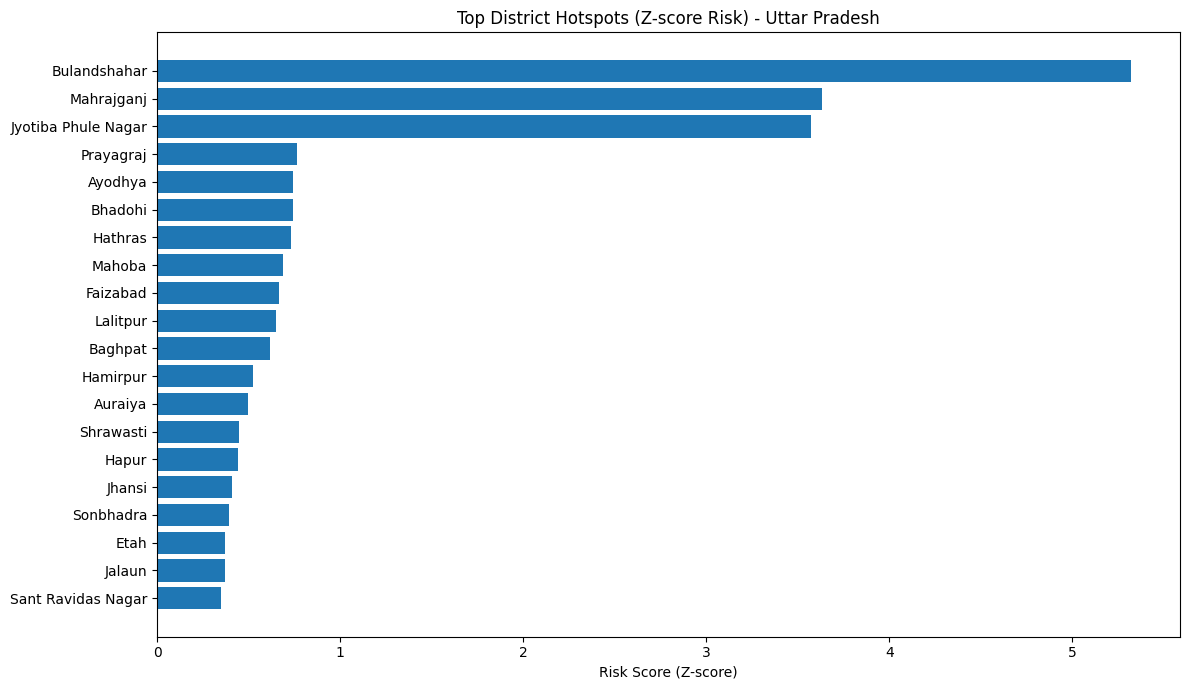

✅ Saved: reports\images\district_hotspots_zscore.png


In [10]:
df_plot = df_dist.sort_values("risk_score", ascending=True)

plt.figure(figsize=(12,7))
plt.barh(df_plot["district"], df_plot["risk_score"])
plt.title(f"Top District Hotspots (Z-score Risk) - {TARGET_STATE}")
plt.xlabel("Risk Score (Z-score)")
plt.tight_layout()
plt.show()

img_hotspots = OUT_IMG / "district_hotspots_zscore.png"

plt.figure(figsize=(12,7))
plt.barh(df_plot["district"], df_plot["risk_score"])
plt.title(f"Top District Hotspots (Z-score Risk) - {TARGET_STATE}")
plt.xlabel("Risk Score (Z-score)")
plt.tight_layout()
plt.savefig(img_hotspots)
plt.close()

print("✅ Saved:", img_hotspots)


Biometric hotspots

In [6]:
from backend.ml.common import list_biometric_districts
from backend.ml.risk.biometric_district_scoring import compute_biometric_district_risk

# ✅ Do NOT re-resolve target state again
districts = list_biometric_districts(TARGET_STATE, limit=300)

print("Biometric districts:", len(districts), "sample:", districts[:5])

bio_rows = []
skip_reasons = {}

for d in districts:
    out = compute_biometric_district_risk(TARGET_STATE, d)

    if out.get("status") == "success":
        bio_rows.append({
            "district": out["district"],
            "bio_risk_score": out["bio_risk_score"],
            "bio_gap_abs_mean": out["components"]["bio_gap_abs_mean"],
            "bio_negative_gap_ratio": out["components"]["bio_negative_gap_ratio"],
        })
    else:
        r = out.get("reason", "unknown")
        skip_reasons[r] = skip_reasons.get(r, 0) + 1

print("Total districts checked:", len(districts))
print("Biometric successful rows:", len(bio_rows))
print("Skip reasons:", skip_reasons)

df_bio = pd.DataFrame(bio_rows)

if df_bio.empty:
    print("⚠️ No biometric hotspot data available at district level.")
    df_bio = pd.DataFrame(columns=["district", "bio_risk_score"])
else:
    df_bio = df_bio.sort_values("bio_risk_score", ascending=False).head(20)

df_bio


Biometric districts: 90 sample: ['Lucknow', 'Jaunpur', 'Azamgarh', 'Kanpur Nagar', 'Rae Bareli']
Total districts checked: 90
Biometric successful rows: 86
Skip reasons: {'sparse_bio_series len=1': 4}


,district,bio_risk_score,bio_gap_abs_mean,bio_negative_gap_ratio
84,Raebareli,10.033443,23103.342778,1.0
82,Kushinagar *,10.032106,23059.241833,1.0
81,Sant Ravidas Nagar Bhadohi,9.937859,20154.396333,1.0
85,Bagpat,9.923113,19734.239167,1.0
83,Mahrajganj,9.902378,19158.245294,1.0
79,Bulandshahar,9.885893,18712.303833,1.0
75,Barabanki,9.885330,18697.258167,1.0
72,Bhadohi,9.885323,18697.079167,1.0
43,Ayodhya,9.885193,18693.598500,1.0
19,Prayagraj,9.884145,18665.640333,1.0


Plot biometric hotspots

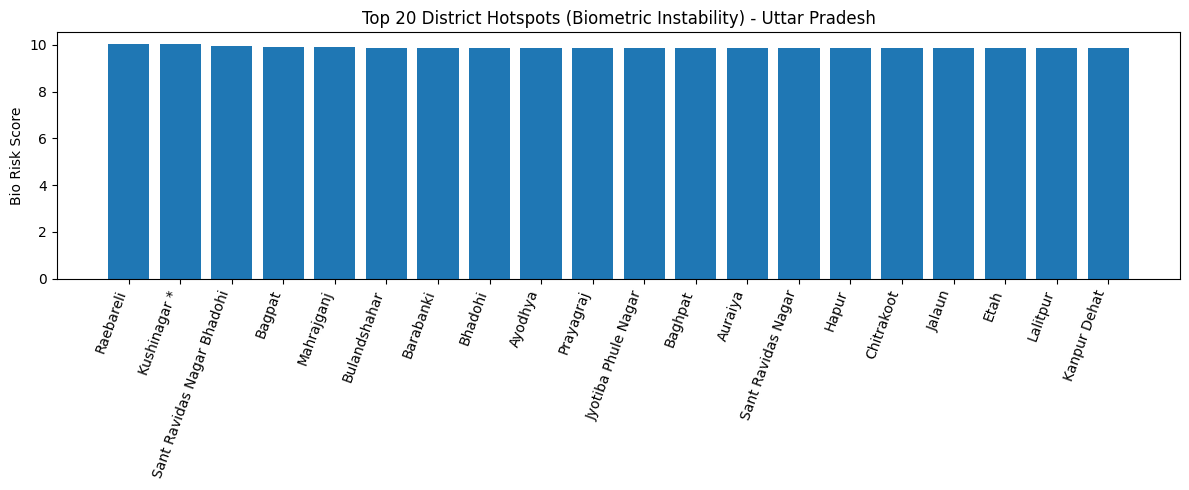

Saved: reports\images\district_hotspots_biometric.png


In [7]:
plt.figure(figsize=(12,5))
plt.bar(df_bio["district"], df_bio["bio_risk_score"])
plt.xticks(rotation=70, ha="right")
plt.title(f"Top 20 District Hotspots (Biometric Instability) - {TARGET_STATE}")
plt.ylabel("Bio Risk Score")
plt.tight_layout()
plt.show()

img3 = OUT_IMG / "district_hotspots_biometric.png"
plt.figure(figsize=(12,5))
plt.bar(df_bio["district"], df_bio["bio_risk_score"])
plt.xticks(rotation=70, ha="right")
plt.title(f"Top 20 District Hotspots (Biometric Instability) - {TARGET_STATE}")
plt.ylabel("Bio Risk Score")
plt.tight_layout()
plt.savefig(img3)
plt.close()

print("Saved:", img3)


Save CSV outputs

In [11]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")

csv_top = OUT_DIR / f"top10_states_{ts}.csv"
csv_dist = OUT_DIR / f"district_hotspots_enrolment_{TARGET_STATE.replace(' ','_')}_{ts}.csv"
csv_bio = OUT_DIR / f"district_hotspots_biometric_{TARGET_STATE.replace(' ','_')}_{ts}.csv"

df_top.to_csv(csv_top, index=False)
df_dist.to_csv(csv_dist, index=False)
df_bio.to_csv(csv_bio, index=False)

print("Saved:", csv_top)
print("Saved:", csv_dist)
print("Saved:", csv_bio)


Saved: reports\top10_states_20260112_044812.csv
Saved: reports\district_hotspots_enrolment_Uttar_Pradesh_20260112_044812.csv
Saved: reports\district_hotspots_biometric_Uttar_Pradesh_20260112_044812.csv


Generate PDF report automatically

In [14]:
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader
from pathlib import Path
from datetime import datetime

# ✅ Image paths (always define again here so NameError never happens)
img1 = OUT_IMG / "top10_states.png"
img2 = OUT_IMG / "district_hotspots_zscore.png"
img3 = OUT_IMG / "district_hotspots_biometric.png"

print("img1 exists:", img1.exists(), img1)
print("img2 exists:", img2.exists(), img2)
print("img3 exists:", img3.exists(), img3)

# ✅ PDF output path
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_path = OUT_DIR / f"UIDAI_Risk_Report_{TARGET_STATE.replace(' ','_')}_{ts}.pdf"

# Create canvas
c = canvas.Canvas(str(pdf_path), pagesize=A4)
width, height = A4

# =========================
# Page 1
# =========================
c.setFont("Helvetica-Bold", 16)
c.drawString(50, height - 60, "UIDAI Trends Platform - Risk Report")

c.setFont("Helvetica", 11)
c.drawString(50, height - 85, f"Generated: {datetime.now().strftime('%d-%m-%Y %H:%M:%S')}")
c.drawString(50, height - 105, f"Target State: {TARGET_STATE}")

c.setFont("Helvetica-Bold", 12)
c.drawString(50, height - 140, "Top 10 Priority States")

# Draw Image 1
if img1.exists():
    c.drawImage(ImageReader(str(img1)), 50, height - 390, width=500, height=220, preserveAspectRatio=True)
else:
    c.setFont("Helvetica", 10)
    c.drawString(50, height - 160, "⚠️ top10_states.png not found")

c.showPage()

# =========================
# Page 2
# =========================
c.setFont("Helvetica-Bold", 12)
c.drawString(50, height - 60, f"Top District Hotspots (Enrolment Instability) - {TARGET_STATE}")

# Draw Image 2
if img2.exists():
    c.drawImage(ImageReader(str(img2)), 50, height - 520, width=580, height=420, preserveAspectRatio=True)
else:
    c.setFont("Helvetica", 10)
    c.drawString(50, height - 80, "⚠️ district_hotspots_zscore.png not found")

c.showPage()

# =========================
# Page 3
# =========================
c.setFont("Helvetica-Bold", 12)
c.drawString(50, height - 60, f"Top District Hotspots (Biometric Instability) - {TARGET_STATE}")

# Draw Image 3
if img3.exists():
    c.drawImage(ImageReader(str(img3)), 50, height - 520, width=580, height=420, preserveAspectRatio=True)
else:
    c.setFont("Helvetica", 10)
    c.drawString(50, height - 80, "⚠️ district_hotspots_biometric.png not found")

# Save PDF
c.save()

print("✅ PDF saved at:", pdf_path)


img1 exists: True reports\images\top10_states.png
img2 exists: True reports\images\district_hotspots_zscore.png
img3 exists: True reports\images\district_hotspots_biometric.png
✅ PDF saved at: reports\UIDAI_Risk_Report_Uttar_Pradesh_20260112_045347.pdf
